# Part 4: Support Vector Machine

### In this section, the cleaned text will be vectorized using TF-IDF and will be used to train a Support Vector Machine (SVM). Specifically, the model used is the sklearn LinearSVC for classification problems.

### This section will also explore and test different methods of fine-tuning the SVM and evaluating its effectiveness

In [ ]:
import sys
!{sys.executable} -m pip install pandas_profiling
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install scikit-learn-intelex
!{sys.executable} -m spacy download en_core_web_md


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearnex import patch_sklearn, config_context
from sklearn.pipeline import make_pipeline
patch_sklearn() # SW AI Accelerator for Intel CPUs. EXCLUDE IF NOT USING INTEL CPU.

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### This section will use the TF-IDF vectorizer to convert the text into vectors

In [33]:
df = pd.read_csv(PROJ_DIR + r"\sc1015-project\dataset\fake_job_postings.csv")

cleaned_text = pd.read_csv('lemmatized_text.csv').squeeze() # convert to pd series
cleaned_text.head()

0     marketing intern us ny new york marketing mis...
1     customer service cloud video production nz  a...
2     commission machinery assistant cma us ia weve...
3     account executive washington dc us dc washing...
4     bill review manager us fl fort worth missing_...
Name: 0, dtype: object

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(cleaned_text)
tfidf_data = vectorizer.transform(cleaned_text)

#### Use `StratifiedShuffleSplit` to allow for stratified sampling. 80/20 train test split with fixed seed to ensure consistency


In [35]:
sss=StratifiedShuffleSplit(n_splits=1, random_state=RANDOM_SPLIT_SEED, test_size=0.2)
X=np.zeros(shape=tfidf_data.shape[0],dtype=np.bool_)
y=np.array(df['fraudulent']) # prediction target

for train_index, test_index in sss.split(X, y):
    X_train, X_test = tfidf_data[train_index,:], tfidf_data[test_index,:]
    y_train, y_test = y[train_index], y[test_index]


#### From Part 1 EDA, we have seen that there exists a significant class imbalance (roughly 20-1) between fraudulent and not. Hence, it is important to consider the effects of this. Here we use ADASYN to generate synthetic data for the minority class.

In [36]:
X_res, y_res = adasyn.fit_resample(X_train, y_train)


#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

####  Here, we use feature selection for dimensionality reduction. Specifically, the default selector will remove all zero variance features.

In [37]:
selector = SelectFromModel(estimator=LinearSVC()).fit(X_res, y_res)
X_select = selector.transform(X_res)
X_select_test = selector.transform(X_test)

#### The SVC will be fitted here and the accuracy score will test the prediction against the labeled output data

In [51]:
svc = LinearSVC().fit(X_select, y_res)
train_pred = svc.predict(X_select)
test_pred = svc.predict(X_select_test)
print(f"SVC train accuracy score: {accuracy_score(train_pred,y_res)}")
print(f"SVC test accuracy score : {accuracy_score(test_pred,y_test)}")


SVC train accuracy score: 0.9998898799691663
SVC test accuracy score : 0.9885346756152126


#### It can be observed that the classification accuracy is very high for both train and test datasets.

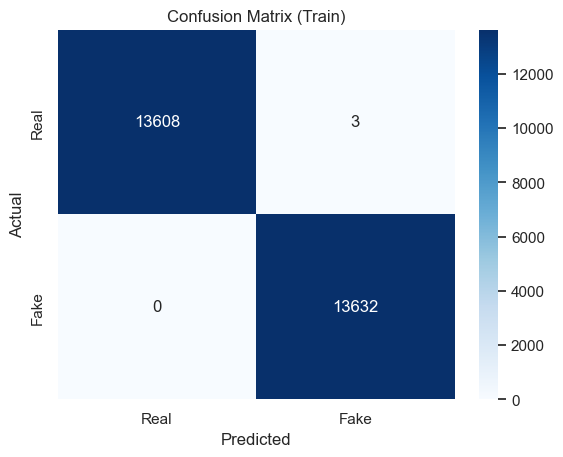

True Positive Rate: 1.0
True Negative Rate: 0.9997795900374697
False Positive Rate: 0.00022040996253030638
False Negative Rate: 0.0
Accuracy: 0.9998898799691663
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.99      0.77      0.87       173

    accuracy                           0.99      3576
   macro avg       0.99      0.89      0.93      3576
weighted avg       0.99      0.99      0.99      3576



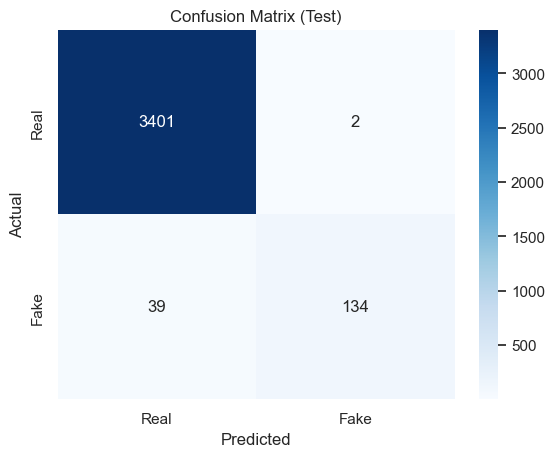

True Positive Rate: 0.7745664739884393
True Negative Rate: 0.9994122832794593
False Positive Rate: 0.0005877167205406994
False Negative Rate: 0.2254335260115607
Accuracy: 0.9885346756152126
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.99      0.77      0.87       173

    accuracy                           0.99      3576
   macro avg       0.99      0.89      0.93      3576
weighted avg       0.99      0.99      0.99      3576



In [52]:
# Calculate the confusion matrix
cm = confusion_matrix(y_res, train_pred)

# Define the class labels
class_names = ['Real', 'Fake']

# Create a heatmap of the confusion matrix
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train)')

# Display the plot
plt.show()

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

TPR = TP / (TP + FN)
print("True Positive Rate:", TPR)
TNR = TN / (TN + FP) 
print("True Negative Rate:", TNR)
FPR = FP / (FP + TN)
print("False Positive Rate:", FPR)
FNR = FN / (TP + FN)
print("False Negative Rate:", FNR)
ACC = (TP + TN) / (TP + FP + FN + TN)
print("Accuracy:", ACC)

print(metrics.classification_report(y_test, test_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Define the class labels
class_names = ['Real', 'Fake']

# Create a heatmap of the confusion matrix
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')

# Display the plot
plt.show()

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

TPR = TP / (TP + FN)
print("True Positive Rate:", TPR)
TNR = TN / (TN + FP) 
print("True Negative Rate:", TNR)
FPR = FP / (FP + TN)
print("False Positive Rate:", FPR)
FNR = FN / (TP + FN)
print("False Negative Rate:", FNR)
ACC = (TP + TN) / (TP + FP + FN + TN)
print("Accuracy:", ACC)

print(metrics.classification_report(y_test, test_pred))

#### Shown above is the confusion matrix for the train and test set. 

#### It can be observed that all stats are good, except for the true positive rate (i.e is fraudulent) which is 0.76. One of the reasons could be that there exist much fewer examples of fraudulent in the dataset. It could also be that the model does not generalize very well to the unseen positive class. Also, it would be appropriate to use the f1-score and disregard the accuracy, since the classes are unbalanced.

C = 0.01
Test accuracy: 0.9588926174496645
TPR: 0.8439306358381503
FPR: 0.03526300323244196
C = 0.05
Test accuracy: 0.9835011185682326
TPR: 0.8323699421965318
FPR: 0.00881575080811049
C = 0.1
Test accuracy: 0.9888143176733781
TPR: 0.8265895953757225
FPR: 0.0029385836027034967
C = 0.2
Test accuracy: 0.9890939597315436
TPR: 0.8092485549132948
FPR: 0.001763150161622098
C = 0.5
Test accuracy: 0.9885346756152126
TPR: 0.7803468208092486
FPR: 0.000881575080811049
C = 0.8
Test accuracy: 0.9888143176733781
TPR: 0.7803468208092486
FPR: 0.0005877167205406994
C = 1
Test accuracy: 0.9888143176733781
TPR: 0.7803468208092486
FPR: 0.0005877167205406994
C = 5
Test accuracy: 0.9885346756152126
TPR: 0.7687861271676301
FPR: 0.0002938583602703497
C = 10
Test accuracy: 0.9885346756152126
TPR: 0.7687861271676301
FPR: 0.0002938583602703497


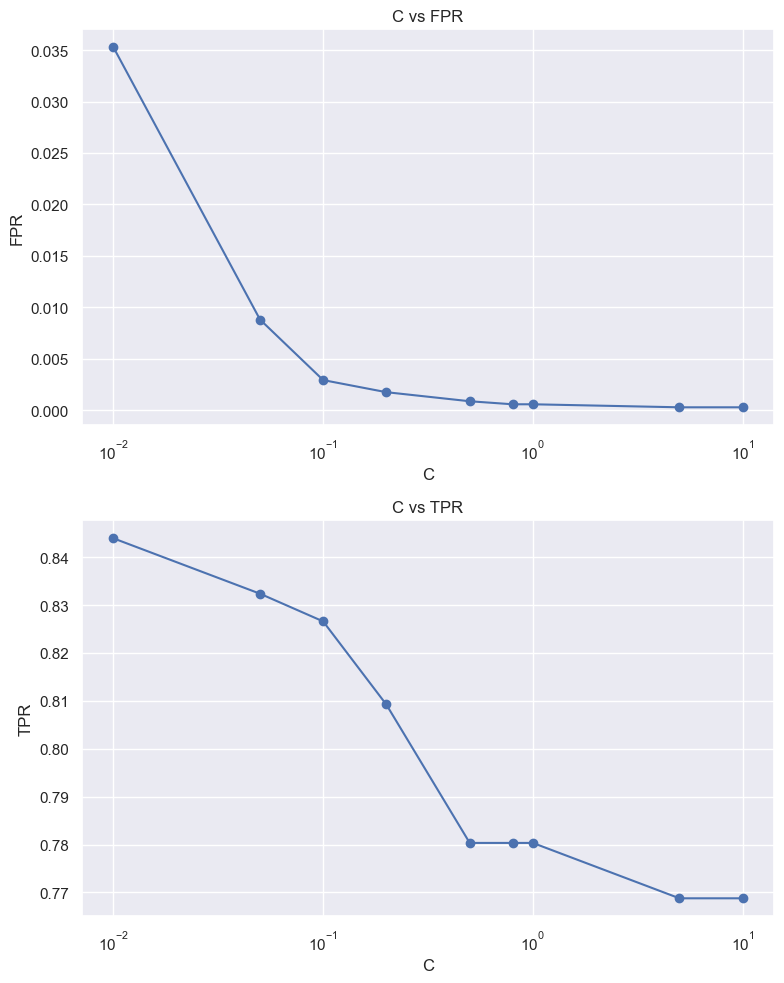

In [40]:
# Initialize arrays to store the TPR and C values
tpr_values = []
fpr_values = []
c_values = []

# Train a linear SVM with different values of C
for C in [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 5, 10]:
    # Fit the classifier to the resampled training data
    with config_context(target_offload="gpu:0"):
        svc = LinearSVC(C=C).fit(X_res, y_res)

    # Predict the classes of the testing data
    y_test_pred = svc.predict(X_test)

    # Compute the accuracy of the classifier on the testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Compute the true positive rate (TPR) and false positive rate (FPR) of the classifier
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    # Store the results
    tpr_values.append(tpr)
    fpr_values.append(fpr)
    c_values.append(C)

    # Print the results
    print(f"C = {C}")
    print(f"Test accuracy: {test_accuracy}")
    print(f"TPR: {tpr}")
    print(f"FPR: {fpr}")

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot C vs FPR
ax1.plot(c_values, fpr_values, marker='o')
ax1.set_xlabel('C')
ax1.set_ylabel('FPR')
ax1.set_xscale('log')
ax1.set_title('C vs FPR')

# Plot C vs TPR
ax2.plot(c_values, tpr_values, marker='o')
ax2.set_xlabel('C')
ax2.set_ylabel('TPR')
ax2.set_xscale('log')
ax2.set_title('C vs TPR')

plt.tight_layout()
plt.show()

#### Based on the plots, it appears that a C value of 0.1 for LinearSVC yields the highest TPR on the test set with the smallest increase of FPR. However, which model is the best will depend on the tolerance for misclassification of negatives (i.e FPR).

SVC train accuracy score: 0.9986785596299967
SVC test accuracy score : 0.9888143176733781


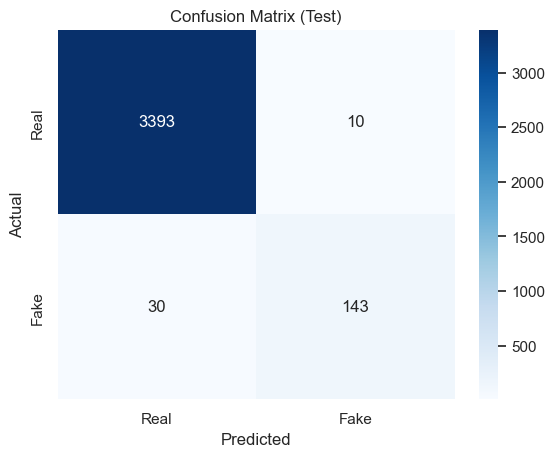

True Positive Rate: 0.8265895953757225
True Negative Rate: 0.9970614163972965
False Positive Rate: 0.0029385836027034967
False Negative Rate: 0.17341040462427745
Accuracy: 0.9888143176733781
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.93      0.83      0.88       173

    accuracy                           0.99      3576
   macro avg       0.96      0.91      0.94      3576
weighted avg       0.99      0.99      0.99      3576



In [50]:
svc = LinearSVC(C=0.1).fit(X_select, y_res)
train_pred = svc.predict(X_select)
test_pred = svc.predict(X_select_test)
print(f"SVC train accuracy score: {accuracy_score(train_pred,y_res)}")
print(f"SVC test accuracy score : {accuracy_score(test_pred,y_test)}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Define the class labels
class_names = ['Real', 'Fake']

# Create a heatmap of the confusion matrix
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')

# Display the plot
plt.show()

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

TPR = TP / (TP + FN)
print("True Positive Rate:", TPR)
TNR = TN / (TN + FP) 
print("True Negative Rate:", TNR)
FPR = FP / (FP + TN)
print("False Positive Rate:", FPR)
FNR = FN / (TP + FN)
print("False Negative Rate:", FNR)
ACC = (TP + TN) / (TP + FP + FN + TN)
print("Accuracy:", ACC)

print(metrics.classification_report(y_test, test_pred))

#### We can see that the TPR has improved significantly, at the cost of a few more negative samples being misclassified. Again, the ideal C-parameter value will depend on the application and tolerance to misclassification. For this particular application (fake jobs), it is entirely possible that there would exist a few instances where the training data is mislabelled to begin with, so the few misclassifications may not be significant. Further, since the usefulness of the model is predicated on the ability to detect fake jobs (positives), a slight increase in false positives may be acceptable.

### Conclusion for Support Vector Machine model

**In conclusion, the best overall performance was achieved using LinearSVC with C=0.1, yielding f1-score of 0.99/0.88, 0.99 TNR, 0.82 TPR. ADASYN oversampling performed better than SMOTE for this particular dataset, and attempting to use non-linear kernels for SVM did not yield gains in performance (see below for some examples).**

C = 0.1
Test accuracy: 0.9767897091722595
TPR: 0.5260115606936416
FPR: 0.0002938583602703497
C = 1
Test accuracy: 0.9832214765100671
TPR: 0.653179190751445
FPR: 0.0
C = 5
Test accuracy: 0.9835011185682326
TPR: 0.6589595375722543
FPR: 0.0
C = 10
Test accuracy: 0.9835011185682326
TPR: 0.6589595375722543
FPR: 0.0
C = 50
Test accuracy: 0.9835011185682326
TPR: 0.6589595375722543
FPR: 0.0


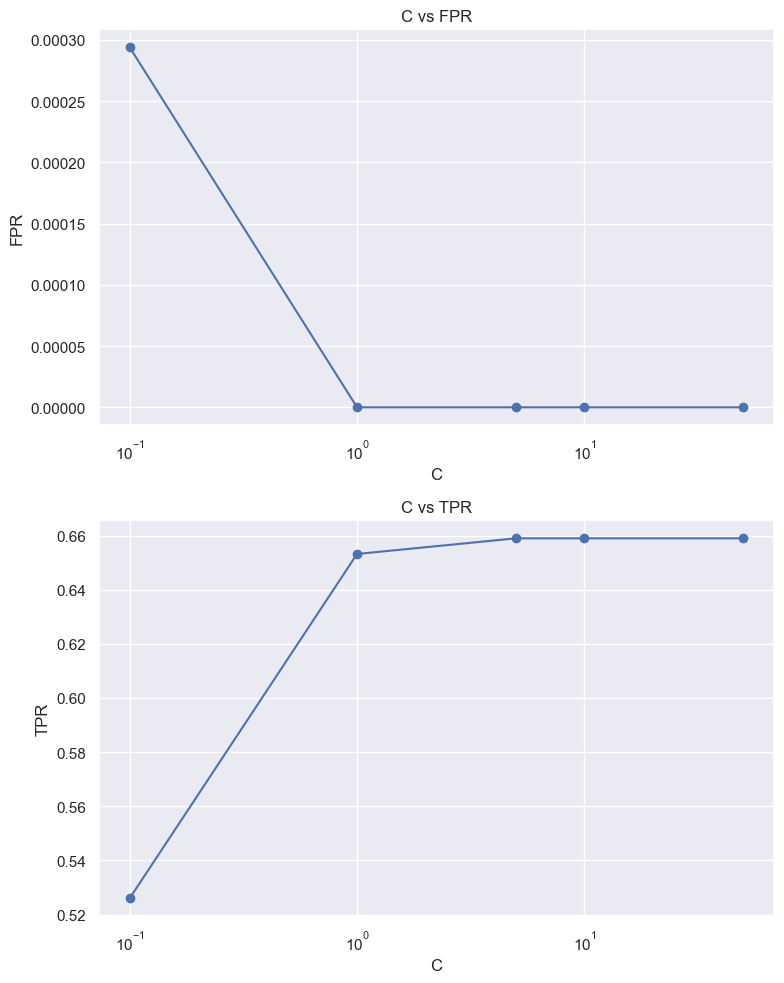

In [42]:
# Initialize arrays to store the TPR and C values
tpr_values = []
fpr_values = []
c_values = []

# Train a linear SVM with different values of C
for C in [0.1, 1, 5, 10, 50]:
    # Fit the classifier to the resampled training data
    svc = SVC(C=C, kernel='poly', degree=3).fit(X_res, y_res)

    # Predict the classes of the testing data
    y_test_pred = svc.predict(X_test)

    # Compute the accuracy of the classifier on the testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Compute the true positive rate (TPR) and false positive rate (FPR) of the classifier
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    # Store the results
    tpr_values.append(tpr)
    fpr_values.append(fpr)
    c_values.append(C)

    # Print the results
    print(f"C = {C}")
    print(f"Test accuracy: {test_accuracy}")
    print(f"TPR: {tpr}")
    print(f"FPR: {fpr}")

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot C vs FPR
ax1.plot(c_values, fpr_values, marker='o')
ax1.set_xlabel('C')
ax1.set_ylabel('FPR')
ax1.set_xscale('log')
ax1.set_title('C vs FPR')

# Plot C vs TPR
ax2.plot(c_values, tpr_values, marker='o')
ax2.set_xlabel('C')
ax2.set_ylabel('TPR')
ax2.set_xscale('log')
ax2.set_title('C vs TPR')

plt.tight_layout()
plt.show()

It appears from testing (here) and on Google Colab that non-linear degree3 and rbf kernels do not perform better than LinearSVC. Additionally, the computations are very expensive (hence the use of colab GPU). Indeed, it seems that for higher degrees, the classification is worse. As above, the degree3 kernel plateaus at 0.66 TPR, which is unacceptable.